# Convolutional Neural Network vs. Vision Transformer for Image Classification

## Setup

### Imports and Models

In [118]:
import numpy as np
import PIL
import torch
from torch.utils.data import DataLoader
import os
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, BitImageProcessor, BitForImageClassification
import time

# Both ViT and BiT models classify images into one of 1000 classes from ImageNet
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224')
feature_extractor = BitImageProcessor.from_pretrained("google/bit-50")
bit_model = BitForImageClassification.from_pretrained("google/bit-50")

### Dataset

In [119]:
class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotations_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, annotations_file), 
            sep=',', header=0, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'), 
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image'] + '.JPEG'
        image = PIL.Image.open(os.path.join(self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

In [120]:
class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, 'val_annotations.txt'),
            sep='\t', header=None, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'),
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image']
        image = PIL.Image.open(os.path.join(
            self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")[
                'pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

### Functions and Loading Data

In [121]:
# Returns the class index of the predicted class
def classify(model, processor, image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx


def load_data(annotations, directory=os.path.join('tiny_imagenet', 'val')):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.JPEG'):
                img = PIL.Image.open(os.path.join(root, file))
                data.append((img, ))
    return data

def load_annotations(directory=os.path.join('tiny_imagenet')):
    filepath = os.path.join(directory, 'val', 'val_annotations.txt')
    annotations = pd.read_csv(filepath, sep='\t', header=None) 
    annotations = annotations.loc[:, [0, 1]].rename(
        columns={0: 'filename', 1: 'wnid'})
    classes = pd.read_csv(os.path.join(directory, 'words.txt'), sep='\t', header=None).rename(columns={0: 'wnid', 1: 'class'})
    annotations['class'] = annotations['wnid'].map(classes.set_index('wnid')['class'])
    annotations.drop(columns=['wnid'], inplace=True)
    return annotations

annotations = load_annotations()

## Demo

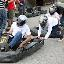

In [123]:
# imgs, labels = next(iter(dataloader))
data = TinyImageNetDataset(os.path.join('tiny_imagenet','val'))
img, label = data[0]
display(img)

In [124]:
vit_pred_idx = classify(vit_model, processor, img)
print("ViT prediction:", vit_model.config.id2label[vit_pred_idx])
bit_pred_idx = classify(bit_model, feature_extractor, img)
print("BiT prediction:", bit_model.config.id2label[bit_pred_idx])
ground_truth = annotations.loc[0 , 'class']
print("Ground truth:", ground_truth)

ViT prediction: go-kart
BiT prediction: go-kart
Ground truth: go-kart


## Analysis

### Tiny ImageNet
- subset of ImageNet-1k
- contains 10,000 images and only 200 of the original 1000 classes

In [125]:
annotations.nunique(0)

filename    10000
class         200
dtype: int64

In [126]:
data_dir = os.path.join('tiny_imagenet', 'val')
vit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=processor), batch_size=64)
bit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=feature_extractor), batch_size=64)

def get_accuracy(model, dataloader):
    correct = 0
    total = len(dataloader.dataset)
    start = time.time()
    with torch.no_grad():
        for imgs, labels in dataloader:
            outputs = model(imgs)
            pred = outputs.logits.argmax(-1)
            correct += (pred == labels).sum().item()
    print(f"Time taken: {time.time()-start:.2f}")
    return correct / total
vit_accuracy = get_accuracy(vit_model, vit_dataloader)
bit_accuracy = get_accuracy(bit_model, bit_dataloader)
print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
    

Time taken: 1880.94
Time taken: 2881.25
ViT Accuracy: 62.07
BiT Accuracy: 33.19


### ImageNet

In [116]:
data_dir = 'imagenet'
annotations_file = 'LOC_val_solution.csv'
vit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=processor), batch_size=64)
bit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=feature_extractor), batch_size=64)


def get_accuracy(model, dataloader):
    correct = 0
    total = dataloader.batch_size * 3
    with torch.no_grad():
        i = 0
        for imgs, labels in dataloader:
            if i > 2:
                break
            outputs = model(imgs)
            pred = outputs.logits.argmax(-1)
            correct += (pred == labels).sum().item()
            i += 1
    return correct / total


vit_accuracy = get_accuracy(vit_model, vit_dataloader)
bit_accuracy = get_accuracy(bit_model, bit_dataloader)
print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
print(f"BiT Accuracy: {bit_accuracy*100:.2f}")

ViT Accuracy: 85.94
BiT Accuracy: 84.90
